In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
import plotnine
from plotnine import *
plotnine.options.figure_size = (12, 8)
warnings.simplefilter(action='ignore')
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction as ae
from cashew import linear_regression as lr

directory = 'expfile_influence/4/'
archives = [os.path.join(directory, f) for f in os.listdir(directory)]
archives

c0a430e3a498fc690b6244ca9909444040c28128


['expfile_influence/4/grenoble_2020-12-07_1965936.zip',
 'expfile_influence/4/grenoble_2020-12-07_1965919.zip',
 'expfile_influence/4/grenoble_2020-12-04_1965808.zip',
 'expfile_influence/4/grenoble_2020-12-06_1965898.zip',
 'expfile_influence/4/grenoble_2020-12-06_1965915.zip',
 'expfile_influence/4/grenoble_2020-12-06_1965895.zip',
 'expfile_influence/4/grenoble_2020-12-05_1965863.zip',
 'expfile_influence/4/grenoble_2020-12-05_1965841.zip',
 'expfile_influence/4/grenoble_2020-12-05_1965826.zip',
 'expfile_influence/4/grenoble_2020-12-05_1965851.zip',
 'expfile_influence/4/grenoble_2020-12-06_1965882.zip',
 'expfile_influence/4/grenoble_2020-12-07_1965924.zip',
 'expfile_influence/4/grenoble_2020-12-05_1965842.zip',
 'expfile_influence/4/grenoble_2020-12-05_1965822.zip',
 'expfile_influence/4/grenoble_2020-12-05_1965864.zip',
 'expfile_influence/4/grenoble_2020-12-05_1965858.zip',
 'expfile_influence/4/grenoble_2020-12-06_1965894.zip',
 'expfile_influence/4/grenoble_2020-12-07_196591

In [2]:
dataframes = []
for archi in archives:
    df = ae.read_performance(archi)
    expfile = ae.read_yaml(archi, 'info.yaml')['expfile'][0]
    df['expfile'] = expfile
    exp = expfile.split('_')
    assert len(exp) == 3
    df['exp_kind'] = exp[1]
    dataframes.append(df)

df = pandas.concat(dataframes)
print(len(df))
df.head()

2150080


,function,m,n,k,timestamp,duration,core,node,cluster,jobid,cpu,start_time,index,expfile_hash,expfile,exp_kind
0,dgemm,2287,5977,512,73.464357,0.545080,0,5,dahu,1965936,0,1607324482,0,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,exp_512_29.csv,512
1,dgemm,3574,3092,512,74.009463,0.443325,0,5,dahu,1965936,0,1607324482,1,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,exp_512_29.csv,512
2,dgemm,9439,1241,512,74.452796,0.471089,0,5,dahu,1965936,0,1607324482,2,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,exp_512_29.csv,512
3,dgemm,1292,5024,512,74.923893,0.263281,0,5,dahu,1965936,0,1607324482,3,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,exp_512_29.csv,512
4,dgemm,1806,8283,512,75.187181,0.595455,0,5,dahu,1965936,0,1607324482,4,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,exp_512_29.csv,512


## Distribution of the sizes

In [3]:
mn = pandas.Series((df['m'] * df['n']).unique())
equi_line = []
for i, med_mn in enumerate(mn.quantile([0.25, 0.5, 0.75])):
    med_mn = int(med_mn)
    tmp = pandas.DataFrame({'m':range(1, med_mn, med_mn//10000)})
    tmp['n'] = med_mn/tmp['m']
    tmp['group'] = i
    equi_line.append(tmp)
equi_line = pandas.concat(equi_line)
equi_line = equi_line[(equi_line['m'] <= df['m'].max()) & (equi_line['n'] <= df['n'].max())]
equi_line.head()

,m,n,group
1,291,9969.972509,0
2,581,4993.566265,0
3,871,3330.955224,0
4,1161,2498.933678,0
5,1451,1999.491385,0


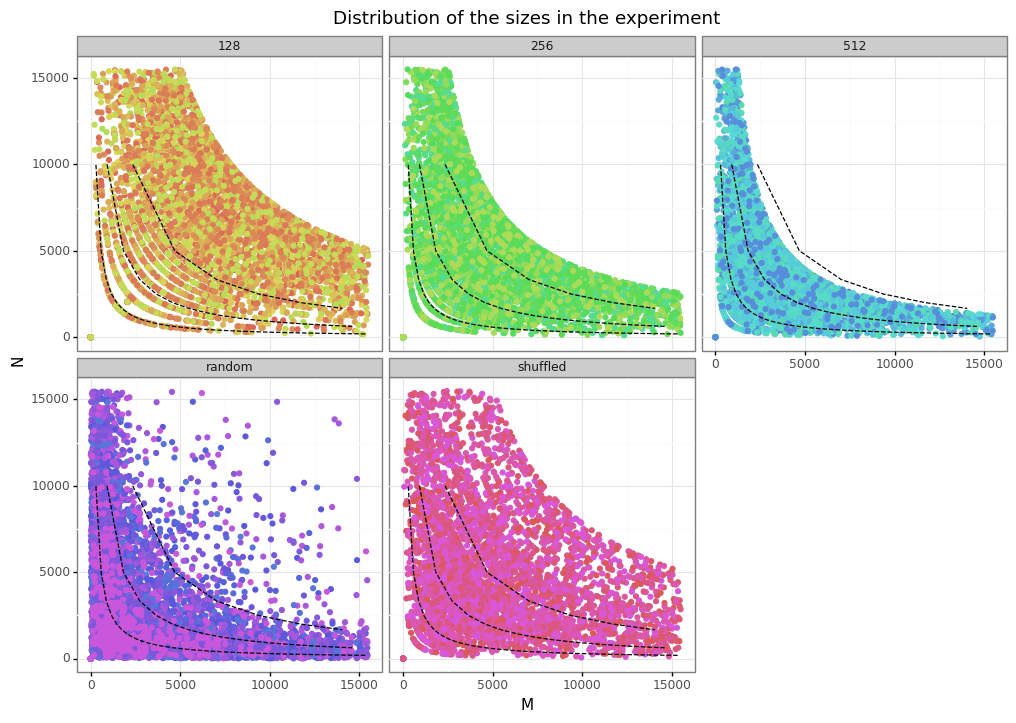

<ggplot: (-9223363268767769109)>


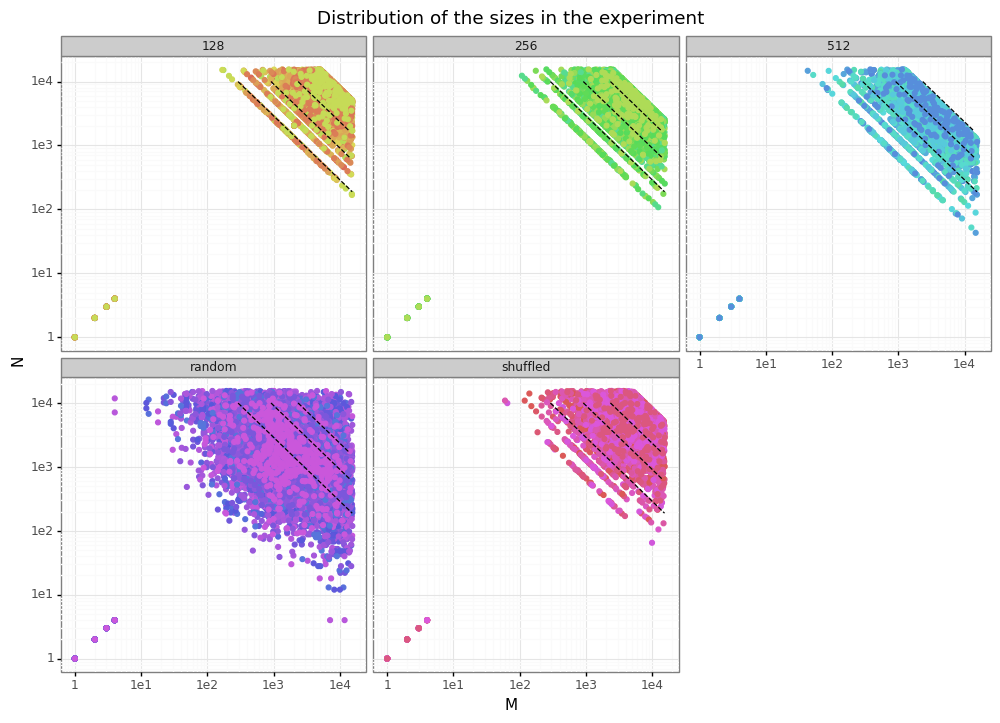

<ggplot: (-9223363268772542390)>


In [4]:
plot = (ggplot(df[['expfile', 'exp_kind', 'm', 'n', 'k']].drop_duplicates())
    + aes(x='m', y='n', color='expfile')
    + geom_point()
    + geom_line(aes(group='group'), data=equi_line, color='black', linetype='dashed')
    + theme_bw()
    + labs(x='M', y='N')
    + ggtitle('Distribution of the sizes in the experiment')
    + expand_limits(y=0)
    + facet_wrap('exp_kind')
    + theme(legend_position='none')
)
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

## Performance

In [5]:
aggregated_df = pandas.DataFrame(lr.regression(df, lr.compute_dgemm_reg)).set_index('jobid')
names = df[['jobid', 'expfile', 'exp_kind']].drop_duplicates().set_index('jobid')
aggregated_df['expfile'] = names['expfile']
aggregated_df['exp_kind'] = names['exp_kind']
aggregated_df = aggregated_df.reset_index()
aggregated_df.head()

,jobid,intercept,mnk,mn,mk,nk,tvalue_mnk,tvalue_mn,tvalue_mk,tvalue_nk,...,tvalue_nk_residual,avg_gflops,function,cluster,node,expfile_hash,cpu,start_time,expfile,exp_kind
0,1965805,0,7.675683e-11,-3.387728e-10,2.267281e-09,3.197056e-09,122.960759,-1.096350,11.321138,15.963751,...,5.547431,25.566414,dgemm,dahu,5,dd235e1daae0c6312cb367f05fd16452977875dad9a8f7...,0,1607104923,exp_512_00.csv,512
1,1965805,0,6.989492e-11,-2.952057e-10,2.167567e-09,2.742593e-09,106.052919,-0.904884,10.251435,12.971000,...,4.171126,28.075153,dgemm,dahu,5,dd235e1daae0c6312cb367f05fd16452977875dad9a8f7...,1,1607104923,exp_512_00.csv,512
2,1965805,0,7.801041e-11,-5.024887e-10,2.383229e-09,3.264616e-09,122.714920,-1.596843,11.685458,16.007078,...,4.610053,25.241952,dgemm,dahu,6,dd235e1daae0c6312cb367f05fd16452977875dad9a8f7...,0,1607104923,exp_512_00.csv,512
3,1965805,0,6.914415e-11,-3.721993e-10,2.252421e-09,2.683304e-09,98.639764,-1.072663,10.015702,11.931681,...,3.519709,28.432530,dgemm,dahu,6,dd235e1daae0c6312cb367f05fd16452977875dad9a8f7...,1,1607104923,exp_512_00.csv,512
4,1965806,0,7.341657e-11,-1.727390e-10,2.290729e-09,2.899725e-09,598.325612,-3.071643,40.733709,51.562873,...,7.652608,25.541307,dgemm,dahu,5,f05f21d76b5fca57aafbbdb382d0f94705523f238830dc...,0,1607106467,exp_random_01.csv,random


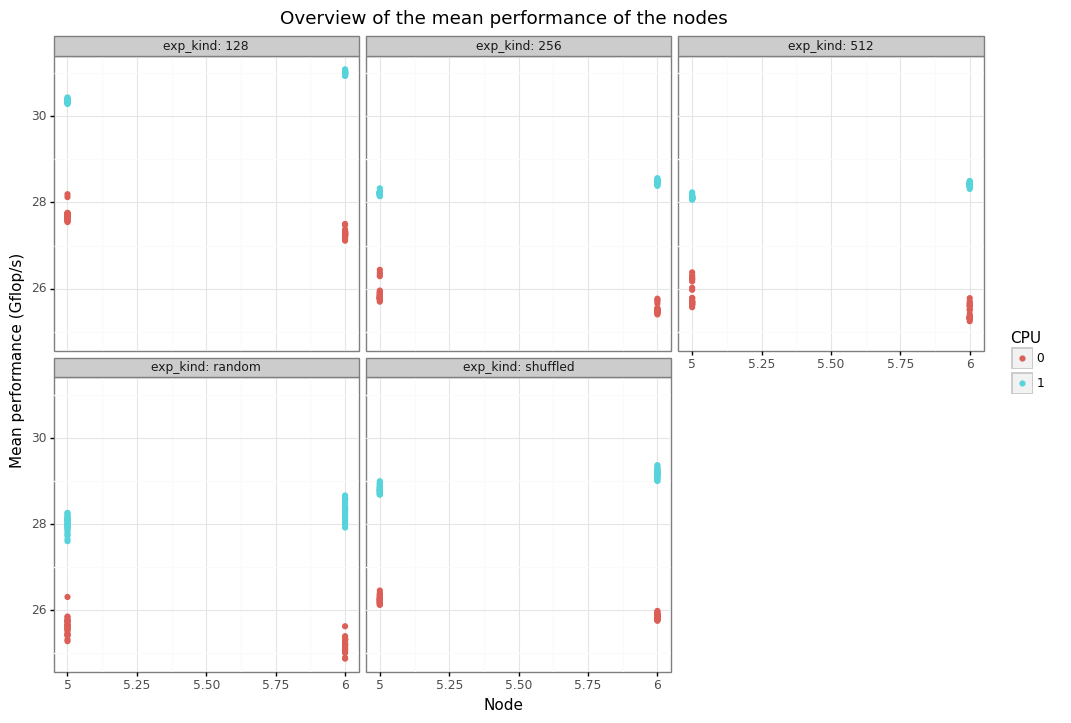

<ggplot: (8768082455304)>

In [6]:
(ggplot(aggregated_df)
    + aes(x='node', y='avg_gflops', color='factor(cpu)')
    + geom_point()
    + theme_bw()
    + facet_wrap('exp_kind', labeller='label_both')
    + labs(x='Node', y='Mean performance (Gflop/s)', color='CPU')
    + ggtitle('Overview of the mean performance of the nodes')
   # + expand_limits(y=0)
)

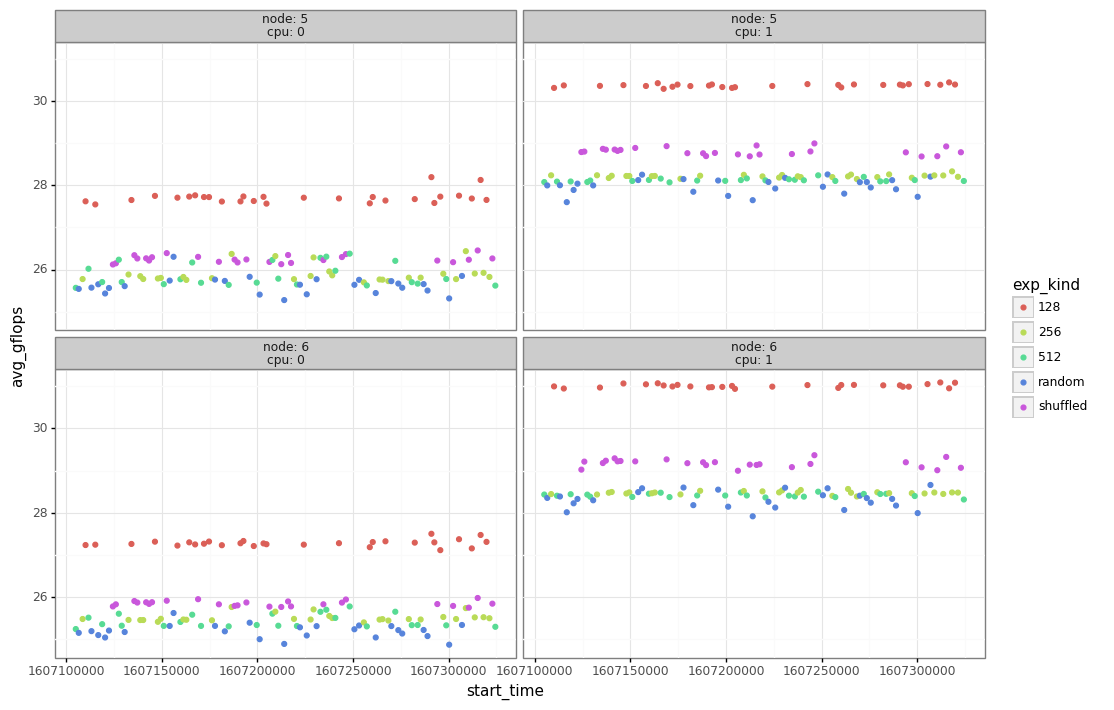

<ggplot: (8768081756592)>


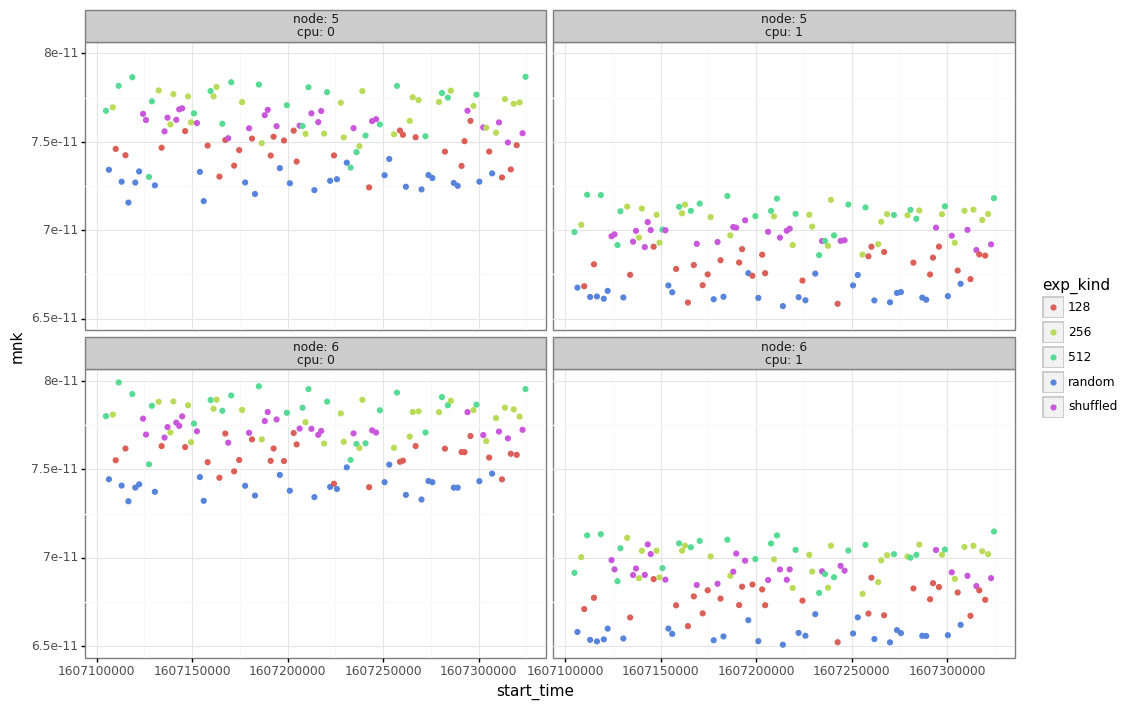

<ggplot: (8768071011462)>


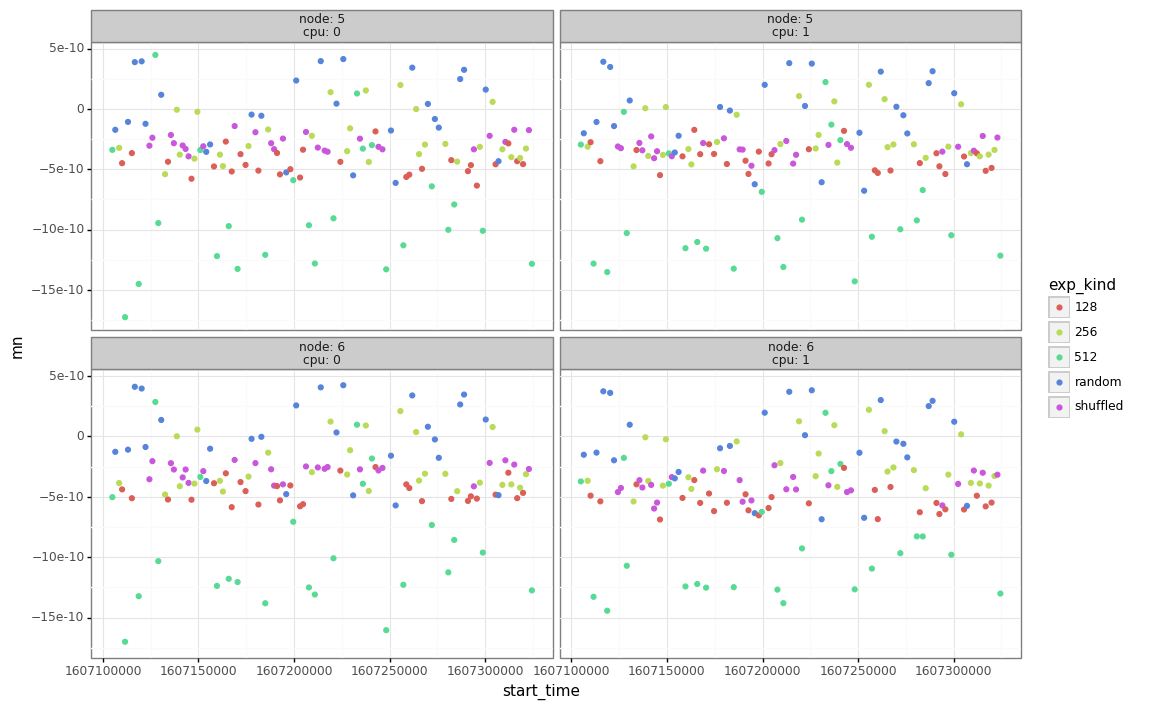

<ggplot: (-9223363268783887286)>


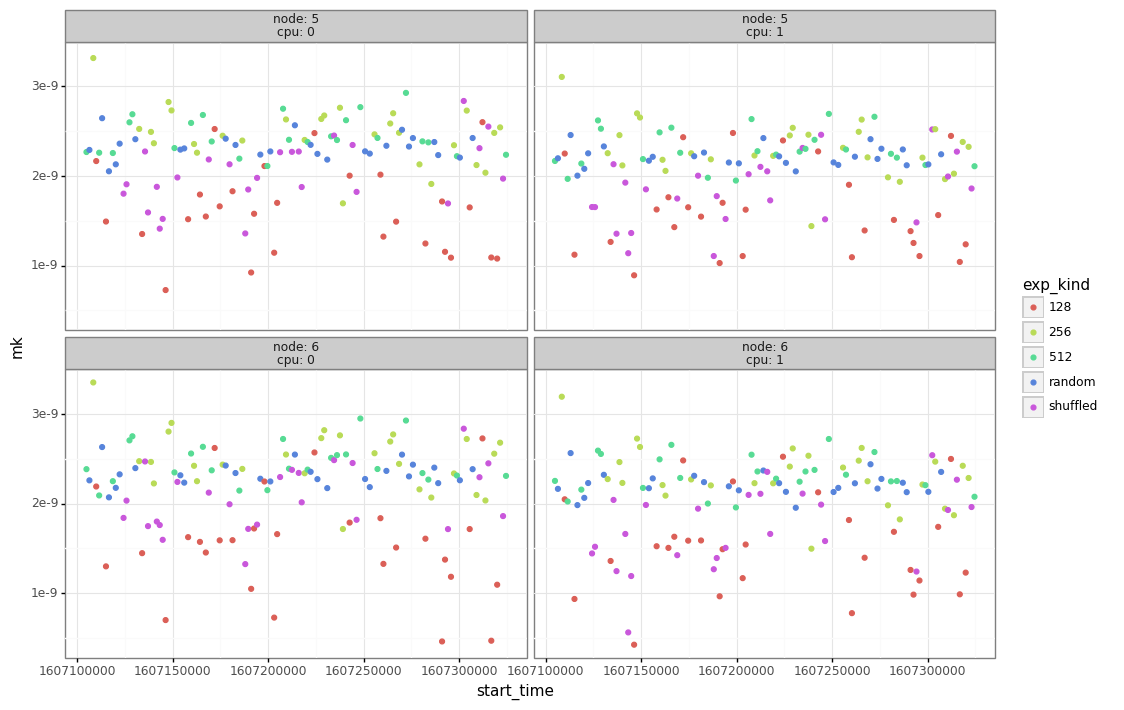

<ggplot: (8768062922518)>


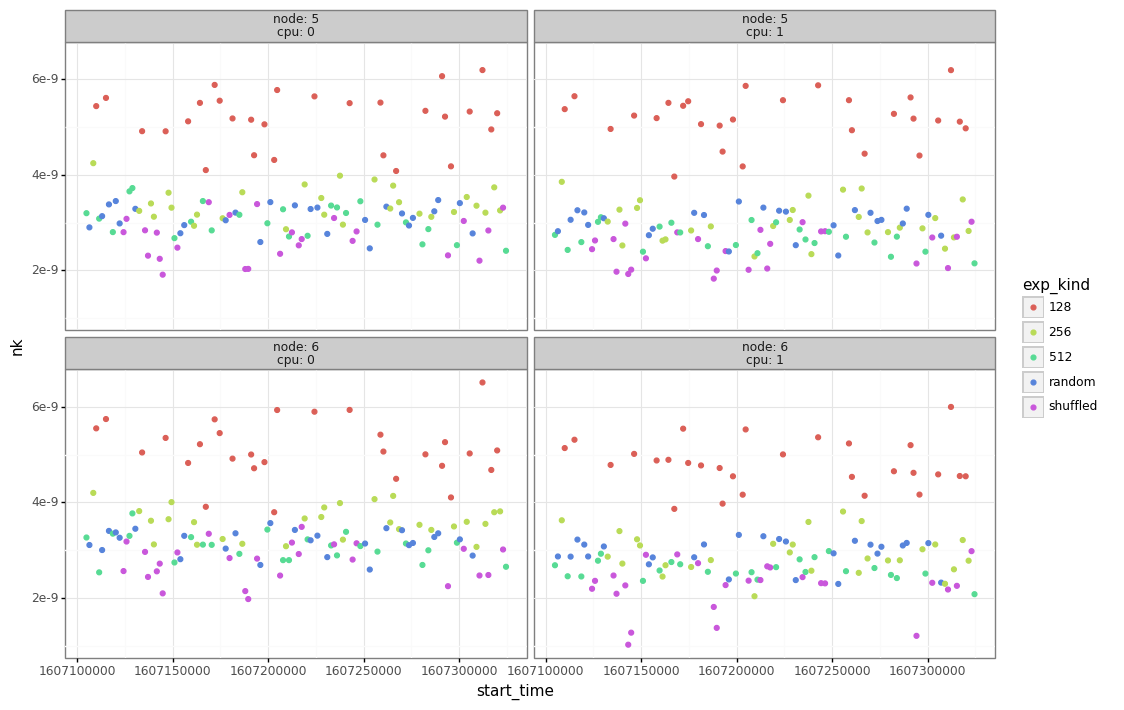

<ggplot: (-9223363268772796391)>


In [7]:
for col in ['avg_gflops', 'mnk', 'mn', 'mk', 'nk']:
    print(ggplot(aggregated_df)
        + aes(x='start_time', y=col, color='exp_kind')
        + geom_point()
        + theme_bw()
        + facet_wrap(['node', 'cpu'], labeller='label_both')
    )

In [8]:
first_exp = set(df.groupby('exp_kind')[['jobid']].min()['jobid'])
df[(df['jobid'].isin(first_exp)) & (df['node'] == 5)][['jobid', 'expfile', 'm', 'n', 'k', 'node', 'cpu', 'duration']].to_csv('/tmp/dgemm_raw_data.csv', index=False)

In [9]:
df[['expfile', 'm', 'n', 'k']].drop_duplicates().to_csv('/tmp/dgemm_expfile_content.csv', index=False)

In [10]:
aggregated_df.to_csv('/tmp/dgemm_agr_data.csv', index=False)

In [11]:
del df
del aggregated_df

## Monitoring

In [12]:
dataframes = []
for f in archives:
    tmp = ae.read_monitoring(f)
    expfile = ae.read_yaml(f, 'info.yaml')['expfile'][0]
    tmp['expfile'] = expfile
    exp = expfile.split('_')
    assert len(exp) == 3
    tmp['exp_kind'] = exp[1]
    dataframes.append(tmp)
monitoring = pandas.concat(dataframes)
monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
for date in monitoring['date'].unique():
    monitoring.loc[monitoring['date'] == date, 'real_start_time'] = monitoring[monitoring['date'] == date]['timestamp'].min()
monitoring['start_exp'] -= monitoring['real_start_time']
monitoring['stop_exp'] -= monitoring['real_start_time']
monitoring['timestamp'] -= monitoring['real_start_time']
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
monitoring['in_exp'] = (monitoring['timestamp'] > monitoring['start_exp'] + 60) & (monitoring['timestamp'] < monitoring['stop_exp'] - 60)
monitoring['hostname'] = monitoring['cluster'] + '-' + monitoring['node'].astype(str)
print(len(monitoring))
monitoring.head()

3283520


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,expfile,exp_kind,date,real_start_time,cpu_id,in_exp,hostname
0,0.000000,dahu,5,1965936,1607324482,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,3.487738,0,0,frequency,622.321337,866.758462,exp_512_29.csv,512,2020-12-07 07:01:22,1.607328e+09,5:0,False,dahu-5
1,5.003542,dahu,5,1965936,1607324482,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,2.654864,0,0,frequency,622.321337,866.758462,exp_512_29.csv,512,2020-12-07 07:01:22,1.607328e+09,5:0,False,dahu-5
2,10.008652,dahu,5,1965936,1607324482,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,3.167687,0,0,frequency,622.321337,866.758462,exp_512_29.csv,512,2020-12-07 07:01:22,1.607328e+09,5:0,False,dahu-5
3,15.059309,dahu,5,1965936,1607324482,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,1.592047,0,0,frequency,622.321337,866.758462,exp_512_29.csv,512,2020-12-07 07:01:22,1.607328e+09,5:0,False,dahu-5
4,20.063506,dahu,5,1965936,1607324482,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,2.799957,0,0,frequency,622.321337,866.758462,exp_512_29.csv,512,2020-12-07 07:01:22,1.607328e+09,5:0,False,dahu-5


In [13]:
grouped_mon = monitoring[monitoring.in_exp].groupby(['node', 'cpu', 'cpu_id', 'kind', 'expfile', 'exp_kind', 'real_start_time'])[['value']].mean().reset_index()
grouped_mon

,node,cpu,cpu_id,kind,expfile,exp_kind,real_start_time,value
0,5,0,5:0,frequency,exp_128_00.csv,128,1.607138e+09,2.100322
1,5,0,5:0,frequency,exp_128_01.csv,128,1.607114e+09,2.100226
2,5,0,5:0,frequency,exp_128_02.csv,128,1.607171e+09,2.115128
3,5,0,5:0,frequency,exp_128_03.csv,128,1.607168e+09,2.104603
4,5,0,5:0,frequency,exp_128_04.csv,128,1.607150e+09,2.106873
...,...,...,...,...,...,...,...,...
1043,6,1,6:1,temperature,exp_shuffled_20.csv,shuffled,1.607306e+09,64.905000
1044,6,1,6:1,temperature,exp_shuffled_22.csv,shuffled,1.607298e+09,65.140000
1045,6,1,6:1,temperature,exp_shuffled_23.csv,shuffled,1.607327e+09,64.700000
1046,6,1,6:1,temperature,exp_shuffled_24.csv,shuffled,1.607315e+09,64.632812


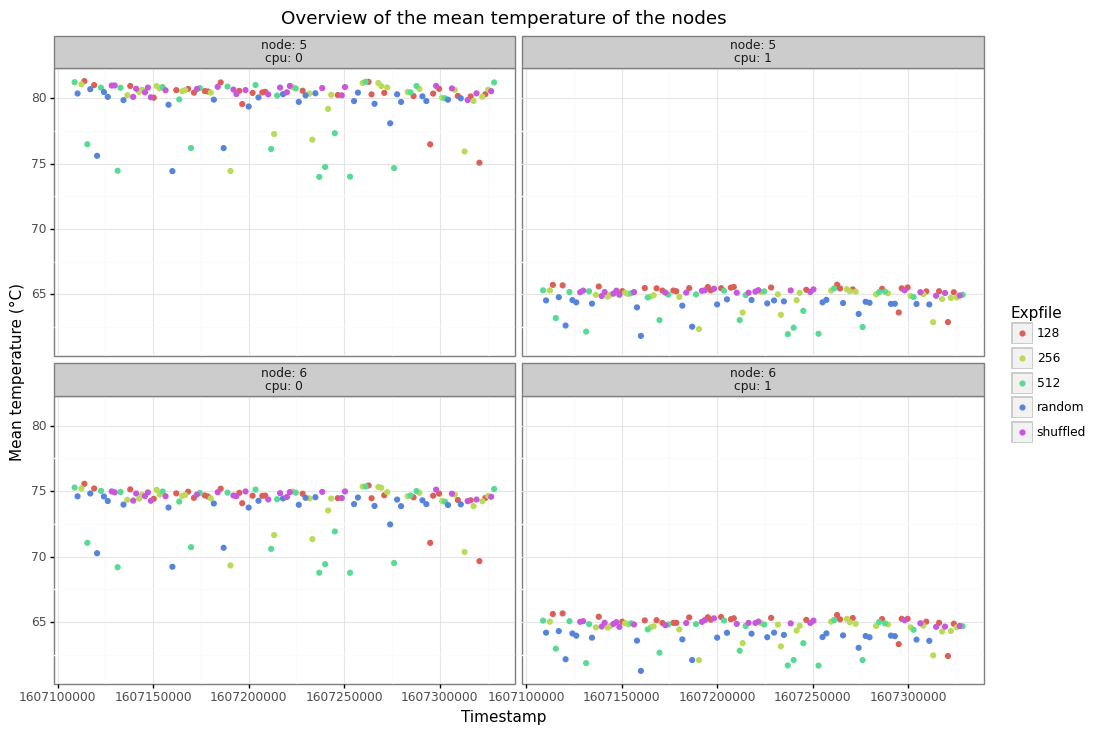

<ggplot: (8768081739391)>

In [14]:
(ggplot(grouped_mon[grouped_mon['kind'] == 'temperature'])
    + aes(x='real_start_time', y='value', color='exp_kind')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'cpu'], labeller='label_both')
    + labs(x='Timestamp', y='Mean temperature (°C)', color='Expfile')
    + ggtitle('Overview of the mean temperature of the nodes')
)

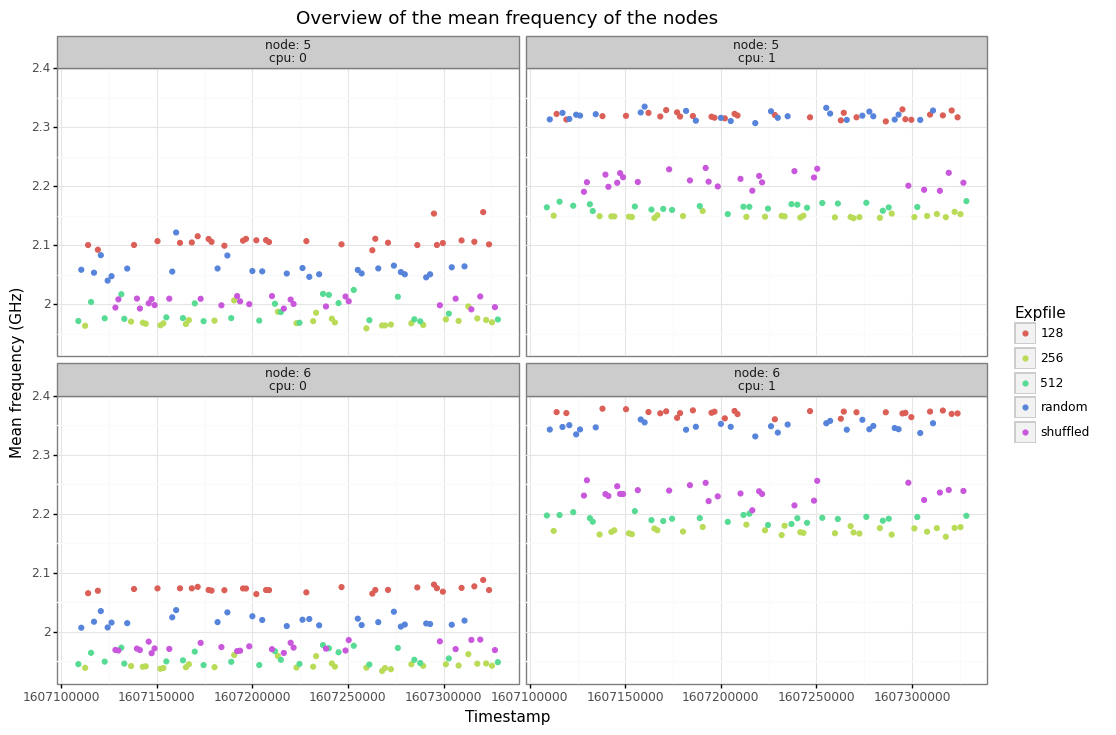

<ggplot: (8768086957425)>

In [15]:
(ggplot(grouped_mon[grouped_mon['kind'] == 'frequency'])
    + aes(x='real_start_time', y='value', color='exp_kind')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'cpu'], labeller='label_both')
    + labs(x='Timestamp', y='Mean frequency (GHz)', color='Expfile')
    + ggtitle('Overview of the mean frequency of the nodes')
)

In [16]:
import re
reg = re.compile('power_package-(?P<cpu_id>[0-9]+)(_(?P<sub_group>[a-z]+))?')
reg.fullmatch('power_package-1').groupdict()

{'cpu_id': '1', 'sub_group': None}

In [17]:
import numpy
import re

def melt_power(df, idcol):
    reg = re.compile('power_package-(?P<cpu_id>[0-9]+)(_(?P<sub_group>[a-z]+))?')
    result = []
    columns = list(df.columns)
    for col in columns:
        match = reg.fullmatch(col)
        if match is None:
            continue
        tmp = df[idcol].copy()
        tmp['value'] = df[col]
        tmp['CPU'] = int(match.groupdict()['cpu_id'])
        tmp['subgroup'] = str(match.groupdict()['sub_group'])
        result.append(tmp)
    return pandas.concat(result)

def read_monitoring_power(archive_name, columns=None):
    '''
    Read the durations of a BLAS calibration in an archive.
    '''
    csv_name = 'monitoring.csv'
    df = ae.read_archive_csv_enhanced(archive_name, csv_name, columns=columns)
    df['timestamp'] = pandas.to_datetime(df['timestamp'])
    columns = ['timestamp', 'cluster', 'node', 'jobid', 'start_time', 'expfile_hash']
    power = melt_power(df, columns)
    power['timestamp'] = power['timestamp'].astype(numpy.int64) / 10 ** 9
    power['timestamp'] = power['timestamp'] - power['timestamp'].min()
    return power

dataframes = []
for f in archives:
    tmp = read_monitoring_power(f)
    expfile = ae.read_yaml(f, 'info.yaml')['expfile'][0]
    tmp['expfile'] = expfile
    exp = expfile.split('_')
    assert len(exp) == 3
    tmp['exp_kind'] = exp[1]
    dataframes.append(tmp)
power = pandas.concat(dataframes)

for jobid in power['jobid'].unique():
    for col in ['start_exp', 'stop_exp']:
        val = monitoring[monitoring['jobid'] == jobid][col].unique()
        assert len(val) == 1
        power.loc[power['jobid'] == jobid, col] = val[0]
power.head()

,timestamp,cluster,node,jobid,start_time,expfile_hash,value,CPU,subgroup,expfile,exp_kind,start_exp,stop_exp
0,0.000000,dahu,5,1965936,1607324482,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,41.728705,1,None,exp_512_29.csv,512,622.321337,866.758462
1,5.003542,dahu,5,1965936,1607324482,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,115.611019,1,None,exp_512_29.csv,512,622.321337,866.758462
2,10.008652,dahu,5,1965936,1607324482,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,84.243800,1,None,exp_512_29.csv,512,622.321337,866.758462
3,15.059309,dahu,5,1965936,1607324482,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,40.010131,1,None,exp_512_29.csv,512,622.321337,866.758462
4,20.063506,dahu,5,1965936,1607324482,14fae83ae98ddd421a667faedd5e785f5fd675d12803c9...,47.198780,1,None,exp_512_29.csv,512,622.321337,866.758462


In [18]:
grouped_power = power[(power['timestamp'] > power['start_exp']+60) & (power['timestamp'] < power['stop_exp']-60)].groupby(['subgroup', 'node', 'CPU', 'expfile', 'exp_kind', 'start_time'])[['value']].mean().reset_index()
grouped_power

,subgroup,node,CPU,expfile,exp_kind,start_time,value
0,None,5,0,exp_128_00.csv,128,1607134047,124.637614
1,None,5,0,exp_128_01.csv,128,1607110027,124.637449
2,None,5,0,exp_128_02.csv,128,1607167379,124.632983
3,None,5,0,exp_128_03.csv,128,1607164303,124.636787
4,None,5,0,exp_128_04.csv,128,1607146346,124.635357
...,...,...,...,...,...,...,...
1043,dram,6,1,exp_shuffled_20.csv,shuffled,1607302372,12.039060
1044,dram,6,1,exp_shuffled_22.csv,shuffled,1607294119,12.136393
1045,dram,6,1,exp_shuffled_23.csv,shuffled,1607322937,12.130086
1046,dram,6,1,exp_shuffled_24.csv,shuffled,1607310603,11.993850


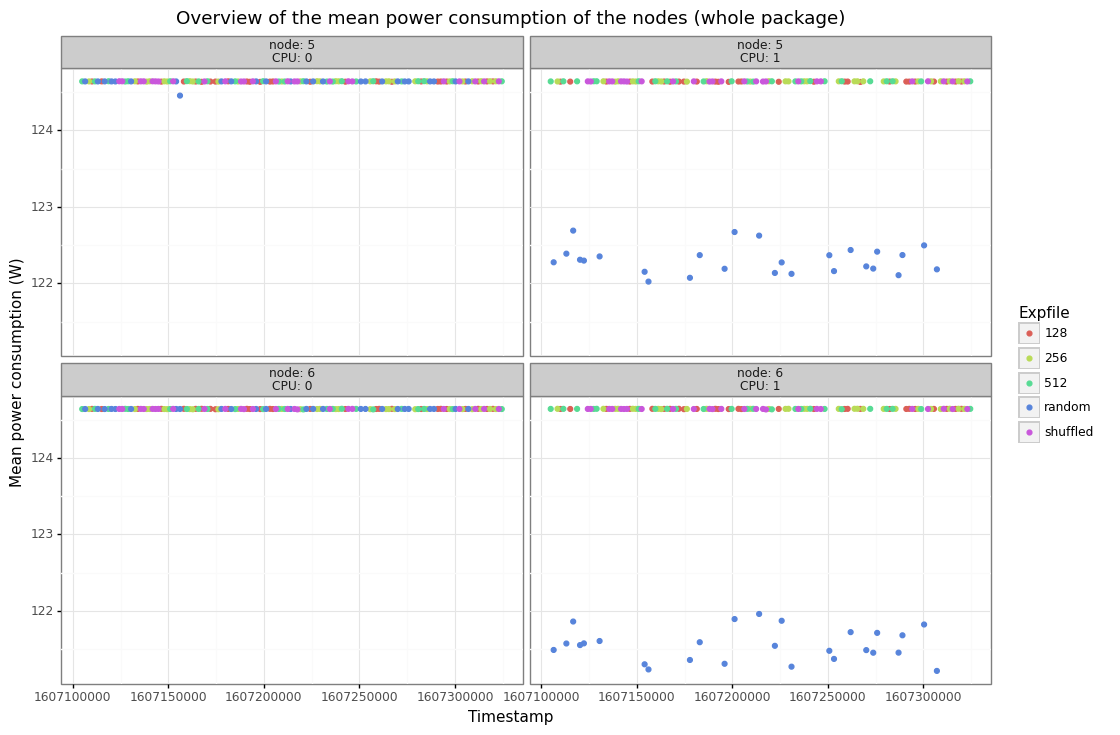

<ggplot: (8768082450461)>

In [19]:
(ggplot(grouped_power[grouped_power['subgroup'] == 'None'])
    + aes(x='start_time', y='value', color='exp_kind')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'CPU'], labeller='label_both')
    + labs(x='Timestamp', y='Mean power consumption (W)', color='Expfile')
    + ggtitle('Overview of the mean power consumption of the nodes (whole package)')
)

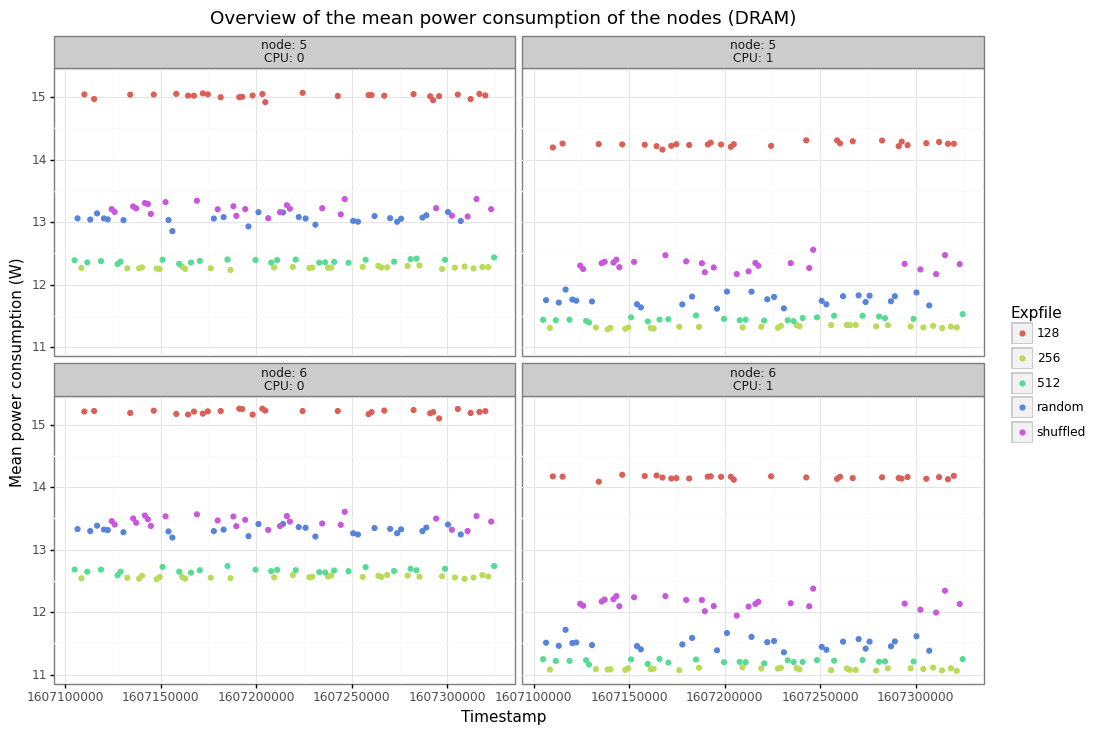

<ggplot: (-9223363268772354139)>

In [20]:
(ggplot(grouped_power[grouped_power['subgroup'] == 'dram'])
    + aes(x='start_time', y='value', color='exp_kind')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'CPU'], labeller='label_both')
    + labs(x='Timestamp', y='Mean power consumption (W)', color='Expfile')
    + ggtitle('Overview of the mean power consumption of the nodes (DRAM)')
)

In [21]:
tmp_mon = grouped_mon.rename(columns={'real_start_time': 'start_time'})
tmp_pow = grouped_power.rename(columns={'CPU': 'cpu'})
tmp_pow['kind'] = 'power'
tmp_pow.loc[tmp_pow['subgroup'] == 'None', 'subgroup'] = 'package'
dump = pandas.concat([tmp_mon, tmp_pow])[['node', 'cpu', 'kind', 'expfile', 'exp_kind', 'start_time', 'value', 'subgroup']]
dump.to_csv('/tmp/dgemm_agr_monitoring.csv', index=False)
dump

,node,cpu,kind,expfile,exp_kind,start_time,value,subgroup
0,5,0,frequency,exp_128_00.csv,128,1.607138e+09,2.100322,NaN
1,5,0,frequency,exp_128_01.csv,128,1.607114e+09,2.100226,NaN
2,5,0,frequency,exp_128_02.csv,128,1.607171e+09,2.115128,NaN
3,5,0,frequency,exp_128_03.csv,128,1.607168e+09,2.104603,NaN
4,5,0,frequency,exp_128_04.csv,128,1.607150e+09,2.106873,NaN
...,...,...,...,...,...,...,...,...
1043,6,1,power,exp_shuffled_20.csv,shuffled,1.607302e+09,12.039060,dram
1044,6,1,power,exp_shuffled_22.csv,shuffled,1.607294e+09,12.136393,dram
1045,6,1,power,exp_shuffled_23.csv,shuffled,1.607323e+09,12.130086,dram
1046,6,1,power,exp_shuffled_24.csv,shuffled,1.607311e+09,11.993850,dram


In [22]:
tmp_mon = monitoring.copy()
tmp_pow = power.rename(columns={'CPU': 'cpu'})
tmp_pow['kind'] = 'power'
tmp_pow.loc[tmp_pow['subgroup'] == 'None', 'subgroup'] = 'package'
dump = pandas.concat([tmp_mon, tmp_pow])[['jobid', 'node', 'cpu', 'kind', 'expfile', 'exp_kind', 'start_time', 'value', 'subgroup', 'timestamp']]
dump = dump[(dump['jobid'].isin(first_exp)) & (dump['node'] == 5)]
dump.to_csv('/tmp/dgemm_raw_monitoring.csv', index=False)
dump

,jobid,node,cpu,kind,expfile,exp_kind,start_time,value,subgroup,timestamp
0,1965808,5,0,frequency,exp_128_01.csv,128,1607110027,3.080145,NaN,0.000000
1,1965808,5,0,frequency,exp_128_01.csv,128,1607110027,3.699865,NaN,5.005069
2,1965808,5,0,frequency,exp_128_01.csv,128,1607110027,2.668066,NaN,10.006138
3,1965808,5,0,frequency,exp_128_01.csv,128,1607110027,2.971197,NaN,15.011242
4,1965808,5,0,frequency,exp_128_01.csv,128,1607110027,1.491174,NaN,20.016334
...,...,...,...,...,...,...,...,...,...,...
171,1965807,5,0,power,exp_256_00.csv,256,1607108493,8.898747,dram,855.689946
172,1965807,5,0,power,exp_256_00.csv,256,1607108493,8.361862,dram,860.694943
173,1965807,5,0,power,exp_256_00.csv,256,1607108493,8.356005,dram,865.699953
174,1965807,5,0,power,exp_256_00.csv,256,1607108493,8.366966,dram,870.704962
